## What Jacot–Gabriel–Hongler tested for NTK convergence in the NTK paper:

- **NTK convergence & (lack of) drift on synthetic data**
  - Inputs lie on the unit circle; visualize the NTK $\Theta(x_0,x)$ at initialization and after training.
  - Compare multiple random initializations across small vs. large widths.
  - Observe variance of the NTK shrinking with width and only mild "inflation" during training that vanishes at large width (i.e., the kernel is effectively constant when wide).

- **Long-time solution matches kernel regression**
  - Tiny least-squares task on a few points on the unit circle.
  - ...

- **Dynamics along NTK principal components (MNIST)**
  - Compute principal components (eigenfunctions) of the NTK.
  - ...

# Experiment: Do finite-width MLPs converge to the NTK limit?

**Goal.** Replicate the classic NTK experiments and test whether a trained finite-width ReLU MLP (NTK parameterization) approaches the **infinite-width NTK predictor** as width increases.

---

## Setup

- **Inputs on the unit circle (2D).**
  For angles $\gamma \in [0, 2\pi)$,
  $$
    x(\gamma) = \begin{bmatrix}\cos(\gamma) \\ \sin(\gamma)\end{bmatrix} \in \mathbb{R}^2.
  $$
  Construct a dense grid $\Gamma = \{\gamma_i\}_{i=1}^N$ and the corresponding dataset $X = \{x(\gamma_i)\}_{i=1}^N$.

- **Targets.** Choose a smooth target defined on the circle (e.g., a sinusoid in angle) with optional noise:
  $$
    y(\gamma) = \sin(k\,\gamma) + 0.8\,\sin(m\,\gamma) + \varepsilon,\quad \varepsilon \sim \mathcal N(0,\sigma^2).
  $$
  Example: $k=4, m=16$, $\sigma \in \{0, 0.05\}$.

- **Train/Test split.** (i) Random scattered split (test = complement), or (ii) small least-squares task (e.g., pick $M\in\{4,8,16\}$ anchor angles for training; test on the dense grid).

- **Model (finite net).**
  - Fully-connected ReLU MLP with 2 hidden layers and width $n$ (sweep $n\in\{64,128,256,512,1024,2048,4096,8192\}$).
  - `parameterization='ntk'`, **with biases** (e.g., `b_std=0.05`) to match the analytic kernel.
  - Loss: MSE. Optimizer: **full-batch SGD** with small LR (e.g., $10^{-2}$) to mimic gradient flow.

- **Analytic NTK (infinite width).**
  - Use `kernel_fn(X, X', get='ntk')` (same architecture/activation/bias).
  - NTK predictor (**kernel ridge**):
    $$
      \alpha=(K_{TT}+\lambda I)^{-1} y_T,\qquad \hat y_{\infty}(X)=K_{XT}\,\alpha,
    $$
    with small $\lambda$ (e.g., $10^{-6}$) for numerical stability.

---

## Procedure

1. **Generate unit-circle dataset.**
   - Choose $N$ angles $\Gamma$ (uniform on $[0,2\pi)$), build $X=\{x(\gamma_i)\}$, compute $y(\gamma_i)$.

2. **Split** into train/test (random subset or small least-squares set).

3. **Train the finite network** (width $n$) with full-batch SGD.

4. **Compute the NTK predictor** using `kernel_fn` on train/test and solve the ridge system to obtain $\hat y_{\infty}$.

5. **Evaluate and plot** on a dense angle grid:
   - Finite net predictions $\hat y_n(\gamma)$.
   - NTK predictions $\hat y_{\infty}(\gamma)$.
   - Plot $\gamma \mapsto \hat y_n(\gamma)$ and $\hat y_{\infty}(\gamma)$.
6. **Record discrepancy** (expected to decrease as $n$ grows):
   $
   \mathrm{RelErr}(n)=\frac{\lVert \hat y_n - \hat y_{\infty}\rVert_2}{\lVert \hat y_{\infty}\rVert_2}.
   $
---

## Expected outcomes & notes

- As width **increases**, $\hat y_n \to \hat y_{\infty}$ on the unit circle.
- Using a **small** training set (few anchor angles) highlights interpolation/generalization behavior.
- Keep **architectural parity** (activation, biases, parameterization) between the finite net and `kernel_fn`.
- Full-batch GD best matches NTK gradient flow; adaptive optimizers can change the effective geometry.

In [1]:
import jax
import jax.numpy as jnp
from jax import random, jit, vmap, value_and_grad, jacrev
from jax.flatten_util import ravel_pytree
import optax
import matplotlib.pyplot as plt
import numpy as np

import neural_tangents as nt
from neural_tangents import stax

from typing import Callable, Optional, Tuple, List, Union

# Configure Matplotlib for better inline plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-whitegrid')

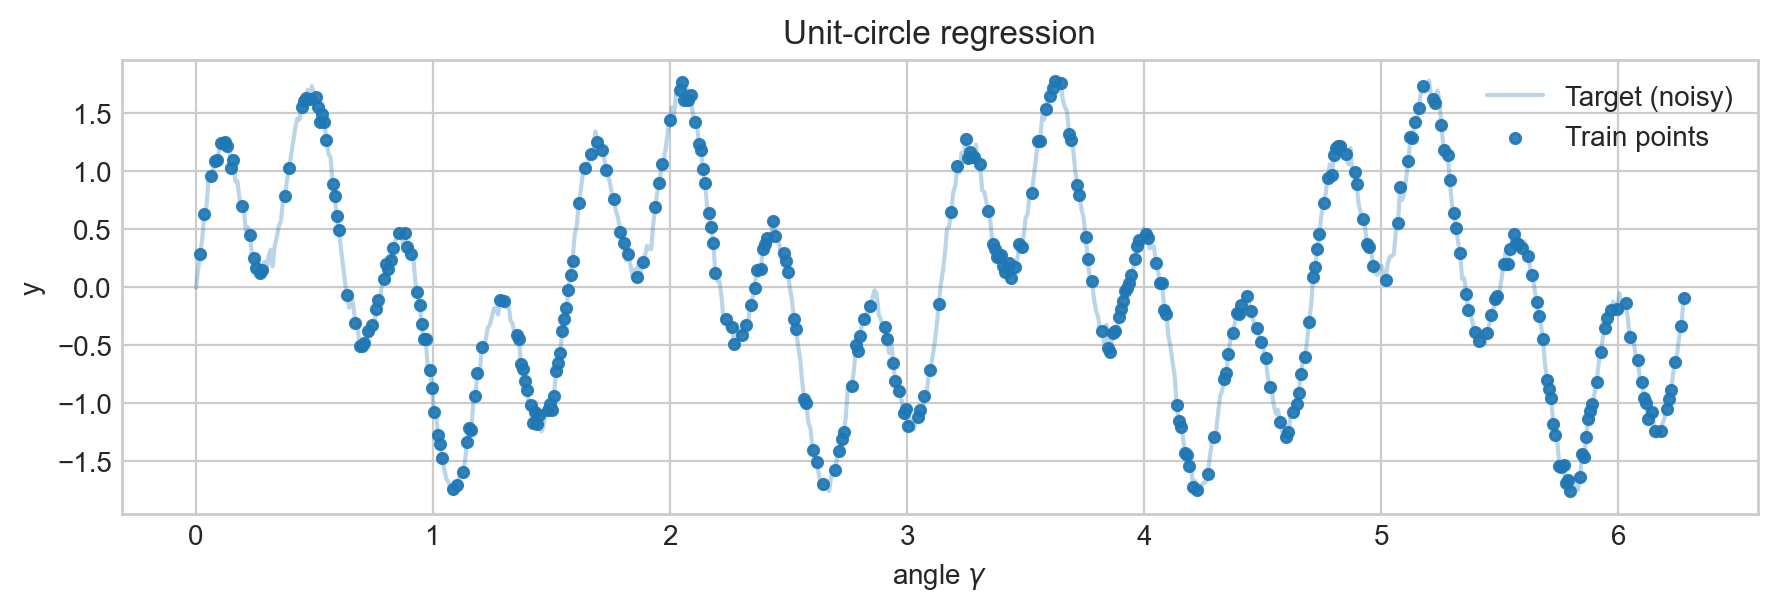

In [2]:
# =====================
# 1) Data on the unit circle
# =====================
key = random.PRNGKey(0)

# Angles on [0, 2pi)
N = 720
gamma = jnp.linspace(0.0, 2*jnp.pi, N, endpoint=False)       # [N]
X = jnp.stack([jnp.cos(gamma), jnp.sin(gamma)], axis=1)      # [N, 2]

# Smooth target on the circle + optional noise
k, m = 4, 16
sigma = 0.05
y_clean = jnp.sin(k*gamma) + 0.8*jnp.sin(m*gamma)            # [N]
y = y_clean + sigma * random.normal(random.PRNGKey(1), y_clean.shape)

# Random scattered train/test split
train_frac = 0.50
n_train = int(train_frac * N)
perm = random.permutation(random.PRNGKey(2), N)
train_idx, test_idx = perm[:n_train], perm[n_train:]

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# For pretty line plots over the circle, use the full ordered grid (gamma, X, y)
order_te = jnp.argsort(jnp.arctan2(X_test[:,1], X_test[:,0]))  # sort test by angle
X_test_plot, y_test_plot = X_test[order_te], y_test[order_te]

# Visualize target around the circle (angle vs value)
plt.figure(figsize=(9, 3.2))
plt.plot(np.asarray(gamma), np.asarray(y), label='Target (noisy)', alpha=0.3)
plt.scatter(np.asarray(gamma[train_idx]), np.asarray(y[train_idx]),
            s=14, alpha=0.9, label='Train points')
plt.xlabel(r'angle $\gamma$'); plt.ylabel('y'); plt.title('Unit-circle regression')
plt.legend(); plt.tight_layout(); plt.show()

In [3]:
X_train.shape, y_train.shape

((360, 2), (360,))

In [4]:
# ------------------------------------------------------------
# Build NTK-parameterized MLP for a given width (input_dim=2)
# ------------------------------------------------------------
def build_mlp(width: int, b_std: float = 0.05, depth_hidden: int = 2):
    layers = []
    for _ in range(depth_hidden):
        layers += [
            stax.Dense(width, b_std=b_std, parameterization='ntk'),
            stax.Relu(),
        ]
    layers += [stax.Dense(1, b_std=b_std, parameterization='ntk')]
    init_fn, apply_fn, kernel_fn = stax.serial(*layers)
    apply_fn = jit(apply_fn)  # speed
    return init_fn, apply_fn, kernel_fn

# ------------------------------------------------------------
# Train finite network (full-batch SGD) until max_steps or tol
# ------------------------------------------------------------
def train_finite(init_fn, apply_fn, X_train, y_train, seed=0, lr=1e-2, max_steps=30000, log_every=1000, tol=1e-8):
    key = random.PRNGKey(seed)
    _, params = init_fn(key, X_train.shape)

    def loss_fn(p, x, y_vec):
        preds = apply_fn(p, x).squeeze()
        return jnp.mean((preds - y_vec) ** 2)

    opt = optax.sgd(lr)
    opt_state = opt.init(params)

    @jit
    def step(p, s, x, y_vec):
        l, g = value_and_grad(loss_fn)(p, x, y_vec)
        up, s = opt.update(g, s, p)
        p = optax.apply_updates(p, up)
        return p, s, l

    # JIT warm-up
    _ = step(params, opt_state, X_train[:8], y_train[:8])

    last_loss = None
    for it in range(1, max_steps + 1):
        params, opt_state, loss = step(params, opt_state, X_train, y_train)
        if (it % log_every == 0) or it == 1 or it == max_steps:
            last_loss = float(loss)
            print(f"[train] step {it:5d} | MSE={last_loss:.3e}")
        if float(loss) <= tol:
            last_loss = float(loss)
            print(f"[train] early stop at step {it} with MSE={last_loss:.3e}")
            break

    return params, last_loss

# ------------------------------------------------------------
# Infinite-width NTK predictor via kernel ridge
# ------------------------------------------------------------
def ntk_predict(kernel_fn, X_train, y_train, X_eval, reg=1e-6):
    K_tt = kernel_fn(X_train, X_train, get='ntk')
    K_xt = kernel_fn(X_eval,  X_train, get='ntk')
    alpha = jnp.linalg.solve(K_tt + reg * jnp.eye(K_tt.shape[0]), y_train[:, None])
    y_pred = (K_xt @ alpha).squeeze()
    return y_pred

# ------------------------------------------------------------
# Run a width sweep and report relative errors vs NTK predictor
# ------------------------------------------------------------
def sweep_widths(widths, X, y, train_frac=0.25, seed_split=2, train_seed=3, lr=1e-2, max_steps=30000, reg=1e-6):
    # 1) Fixed split
    N = X.shape[0]
    perm = random.permutation(random.PRNGKey(seed_split), N)
    n_train = int(train_frac * N)
    train_idx, test_idx = perm[:n_train], perm[n_train:]
    X_train, y_train = X[train_idx], y[train_idx]
    X_eval,  y_eval  = X,           y             # evaluate on full circle

    # Angle order for nice lines
    gamma_eval = jnp.arctan2(X_eval[:, 1], X_eval[:, 0])
    order_eval = np.asarray(jnp.argsort(gamma_eval))

    # 2) Build ONE analytic kernel_fn (any width is fine; kernel is width-independent under 'ntk')
    #    We'll use width=widths[0] just to instantiate a consistent architecture.
    _, _, kernel_fn_ref = build_mlp(width=widths[0], b_std=0.05, depth_hidden=2)

    # 3) Compute NTK predictor ONCE (kernel ridge)
    K_tt = kernel_fn_ref(X_train, X_train, get='ntk')              # [n_tr, n_tr]
    K_xt = kernel_fn_ref(X_eval,  X_train, get='ntk')              # [N, n_tr]
    alpha = jnp.linalg.solve(K_tt + reg * jnp.eye(K_tt.shape[0]), y_train[:, None])  # [n_tr,1]
    y_pred_inf_full = (K_xt @ alpha).squeeze()                     # [N]
    y_inf_sorted = np.asarray(y_pred_inf_full)[order_eval]

    # 4) Train finite nets for each width and compare to the same NTK
    results = []
    preds_per_width = {}  

    for w in widths:
        print(f"\n=== Width {w} ===")
        init_fn, apply_fn, _ = build_mlp(width=w, b_std=0.05, depth_hidden=2)

        params, train_mse = train_finite(
            init_fn, apply_fn, X_train, y_train,
            seed=train_seed, lr=lr, max_steps=max_steps, log_every=2000
        )

        y_pred_finite_full = apply_fn(params, X_eval).squeeze()
        y_fin_sorted = np.asarray(y_pred_finite_full)[order_eval]

        rel_err = float(jnp.linalg.norm(y_pred_finite_full - y_pred_inf_full) /
                        (jnp.linalg.norm(y_pred_inf_full) + 1e-12))
        print(f"[eval] width={w} | RelErr(finite vs NTK) = {rel_err:.4e}")

        results.append((w, rel_err, float(train_mse)))
        preds_per_width[w] = {"y_pred_finite": y_fin_sorted}

    # 5) Plot RelErr vs width
    ws = np.array([r[0] for r in results])
    errs = np.array([r[1] for r in results])

    plt.figure(figsize=(6, 4))
    plt.loglog(ws, errs, marker='o')
    plt.xlabel("width")
    plt.ylabel("RelErr (finite vs NTK)")
    plt.title("Convergence to NTK predictor vs width")
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return results, preds_per_width, order_eval, y_inf_sorted


=== Width 512 ===
[train] step     1 | MSE=1.056e+00
[train] step  2000 | MSE=7.325e-01
[train] step  4000 | MSE=6.301e-01
[train] step  6000 | MSE=5.621e-01
[train] step  8000 | MSE=5.106e-01
[train] step 10000 | MSE=4.700e-01
[train] step 12000 | MSE=4.374e-01
[train] step 14000 | MSE=4.099e-01
[train] step 16000 | MSE=3.872e-01
[train] step 18000 | MSE=3.679e-01
[train] step 20000 | MSE=3.518e-01
[train] step 22000 | MSE=3.379e-01
[train] step 24000 | MSE=3.256e-01
[train] step 26000 | MSE=3.151e-01
[train] step 28000 | MSE=3.059e-01
[train] step 30000 | MSE=2.981e-01
[eval] width=512 | RelErr(finite vs NTK) = 5.6957e-01

=== Width 1024 ===
[train] step     1 | MSE=1.000e+00
[train] step  2000 | MSE=7.621e-01
[train] step  4000 | MSE=6.535e-01
[train] step  6000 | MSE=5.773e-01
[train] step  8000 | MSE=5.210e-01
[train] step 10000 | MSE=4.779e-01
[train] step 12000 | MSE=4.434e-01
[train] step 14000 | MSE=4.154e-01
[train] step 16000 | MSE=3.919e-01
[train] step 18000 | MSE=3.718e-

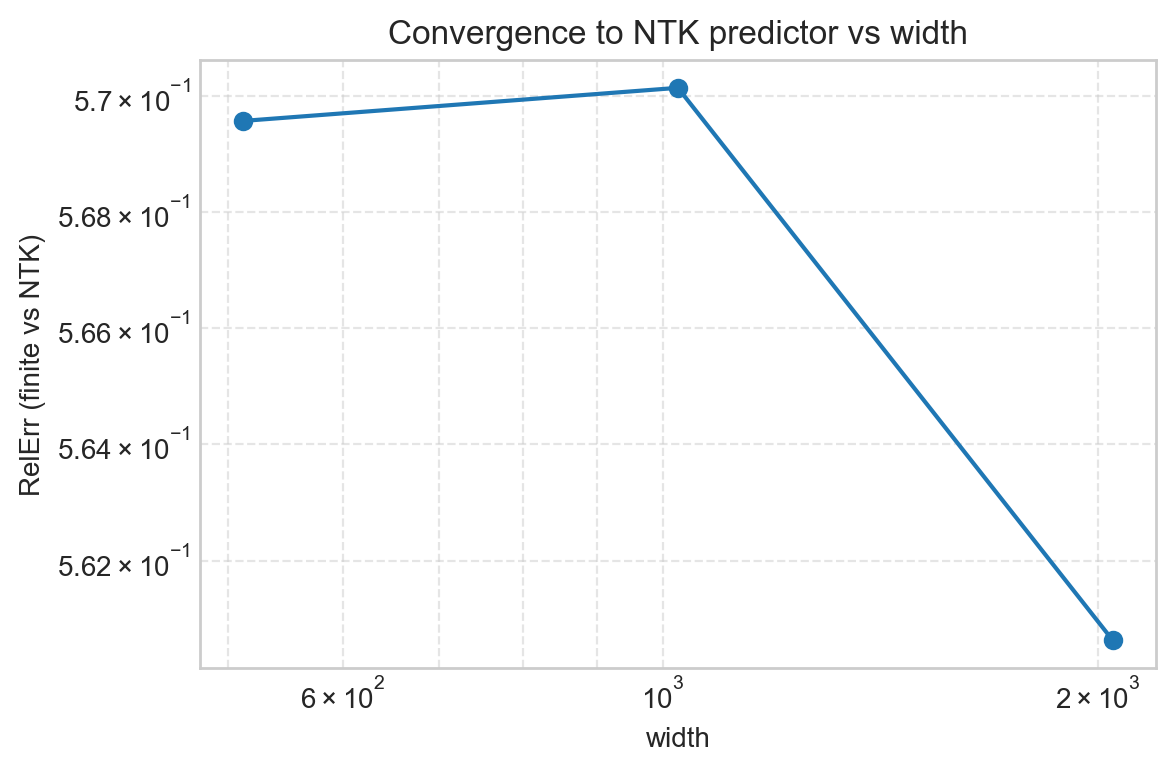

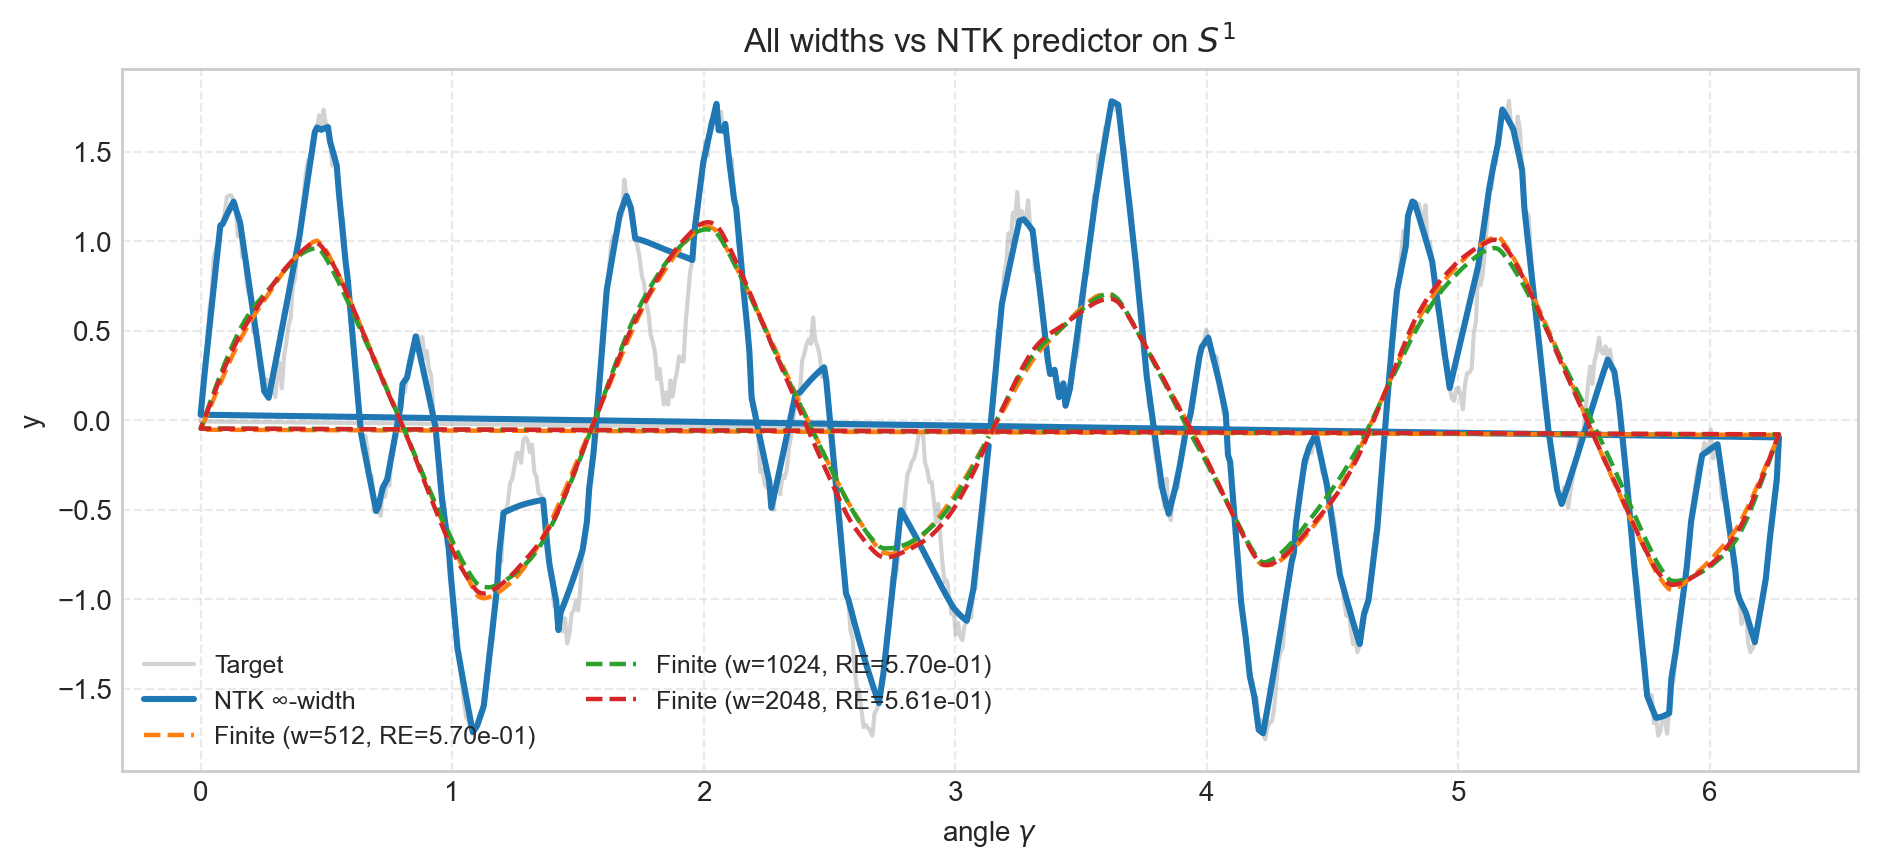

In [6]:
widths = [512, 1024, 2048]
results, preds_per_width, order_eval, y_inf_sorted = sweep_widths(
    widths, X, y, train_frac=0.25, seed_split=2, train_seed=3, lr=1e-2, max_steps=30000, reg=1e-6
)

# --- Single overlay plot: all finite nets vs shared NTK curve ---
gamma_sorted  = np.asarray(jnp.linspace(0.0, 2*jnp.pi, X.shape[0], endpoint=False))[order_eval]
target_sorted = np.asarray(y)[order_eval]
rel_err_map   = {w: err for (w, err, _mse) in results}

plt.figure(figsize=(9.5, 4.5))
plt.plot(gamma_sorted, target_sorted, color='gray', alpha=0.35, label='Target')
plt.plot(gamma_sorted, y_inf_sorted,  lw=2.2, label='NTK $\infty$-width')

for w in widths:
    y_fin_sorted = preds_per_width[w]["y_pred_finite"]
    label = f'Finite (w={w}, RE={rel_err_map[w]:.2e})'
    plt.plot(gamma_sorted, y_fin_sorted, '--', lw=1.6, label=label)

plt.xlabel(r'angle $\gamma$'); plt.ylabel('y')
plt.title('All widths vs NTK predictor on $S^1$')
plt.legend(ncol=2, fontsize=9)
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [17]:
# # =====================
# # 2) Define NTK-parameterized MLP (input dim = 2)
# # =====================
# width = 10000
# init_fn, apply_fn, kernel_fn = stax.serial(
#     stax.Dense(width, b_std=0.05, parameterization='ntk'),
#     stax.Relu(),
#     stax.Dense(1,    b_std=0.05, parameterization='ntk')
# )
# apply_fn = jit(apply_fn)

# # Init params
# _, params = init_fn(random.PRNGKey(3), X_train.shape)

In [18]:
# # =====================
# # 3) Train finite network with full-batch SGD
# # =====================
# def loss_fn(p, x, y_vec):
#     preds = apply_fn(p, x).squeeze()
#     return jnp.mean((preds - y_vec)**2)

# opt = optax.sgd(learning_rate=1e-2)
# opt_state = opt.init(params)

# @jit
# def step(p, s, x, y_vec):
#     l, g = value_and_grad(loss_fn)(p, x, y_vec)
#     up, s = opt.update(g, s, p)
#     p = optax.apply_updates(p, up)
#     return p, s, l

# # Warm-up JIT
# _ = step(params, opt_state, X_train[:8], y_train[:8])

# n_steps = 30000
# log_every = 1000
# for it in range(1, n_steps+1):
#     params, opt_state, loss = step(params, opt_state, X_train, y_train)
#     if it % log_every == 0 or it == 1 or it == n_steps:
#         tr = float(loss_fn(params, X_train, y_train))
#         te = float(loss_fn(params, X_test,  y_test))
#         print(f"step {it:5d} | train MSE={tr:.4e} | test MSE={te:.4e}")

step     1 | train MSE=9.5038e-01 | test MSE=9.7709e-01
step  1000 | train MSE=7.9576e-01 | test MSE=7.9518e-01
step  2000 | train MSE=7.2581e-01 | test MSE=7.2290e-01
step  3000 | train MSE=6.6658e-01 | test MSE=6.6361e-01
step  4000 | train MSE=6.1579e-01 | test MSE=6.1335e-01
step  5000 | train MSE=5.7212e-01 | test MSE=5.7058e-01
step  6000 | train MSE=5.3453e-01 | test MSE=5.3412e-01
step  7000 | train MSE=5.0209e-01 | test MSE=5.0302e-01
step  8000 | train MSE=4.7406e-01 | test MSE=4.7650e-01
step  9000 | train MSE=4.4972e-01 | test MSE=4.5381e-01
step 10000 | train MSE=4.2862e-01 | test MSE=4.3443e-01
step 11000 | train MSE=4.1028e-01 | test MSE=4.1786e-01
step 12000 | train MSE=3.9429e-01 | test MSE=4.0368e-01
step 13000 | train MSE=3.8030e-01 | test MSE=3.9150e-01
step 14000 | train MSE=3.6805e-01 | test MSE=3.8102e-01
step 15000 | train MSE=3.5728e-01 | test MSE=3.7200e-01
step 16000 | train MSE=3.4776e-01 | test MSE=3.6420e-01
step 17000 | train MSE=3.3934e-01 | test MSE=3.5

In [19]:
# # =====================
# # 4) Infinite-width NTK predictor (kernel ridge with analytic NTK)
# # =====================
# reg = 1e-6
# K_tt = kernel_fn(X_train, X_train, get='ntk')                         # [n_tr, n_tr]
# K_xt = kernel_fn(X,        X_train, get='ntk')                         # [N, n_tr]
# alpha = jnp.linalg.solve(K_tt + reg*jnp.eye(K_tt.shape[0]), y_train[:, None])  # [n_tr, 1]
# y_pred_inf_full = (K_xt @ alpha).squeeze()                             # on full angle grid

In [20]:
# # =====================
# # 5) Finite-net predictions on the full angle grid
# # =====================
# y_pred_finite_full = apply_fn(params, X).squeeze()

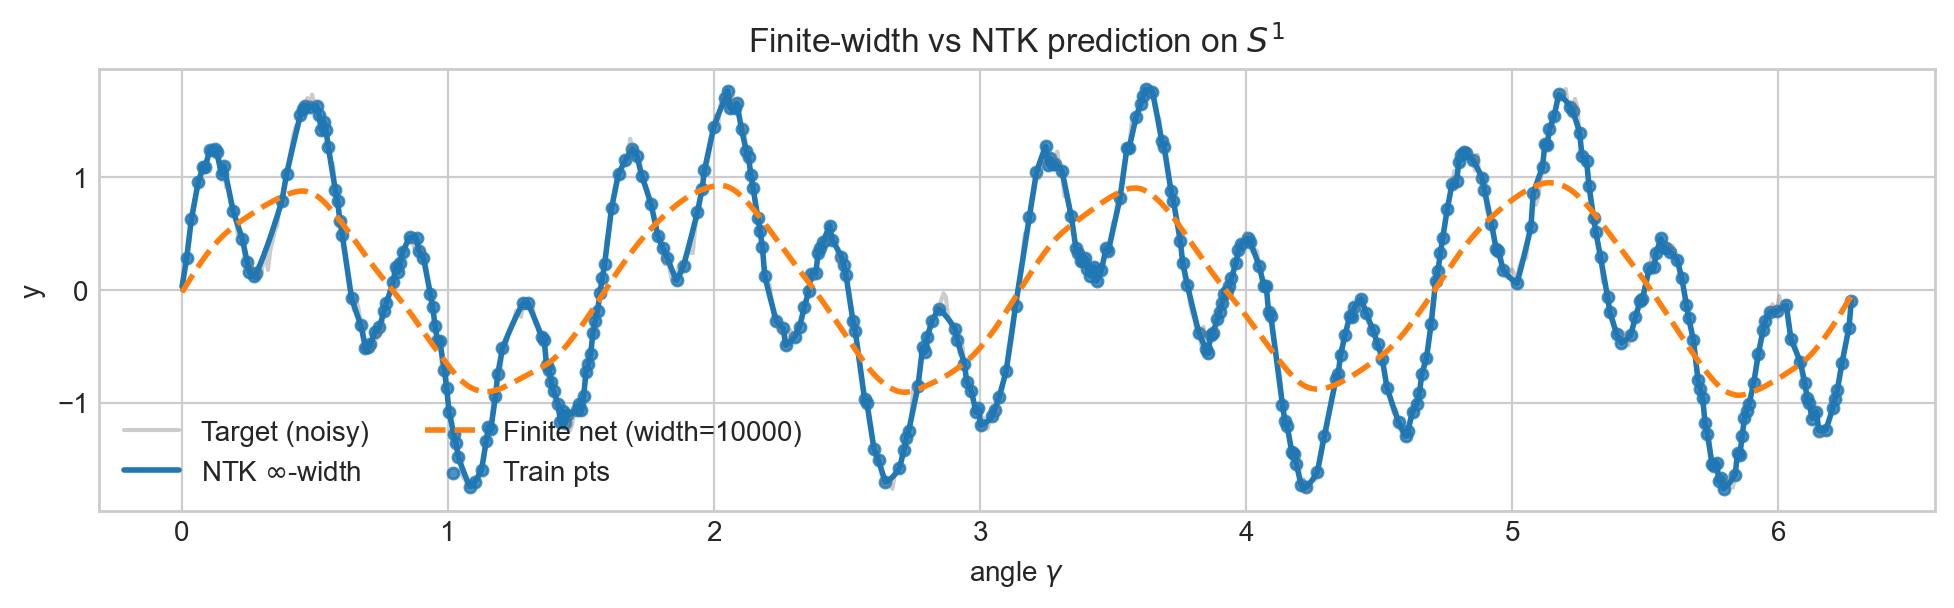

Relative prediction error (finite vs NTK): 6.010e-01


In [21]:
# # =====================
# # 6) Plot around the circle (angle vs value)
# # =====================
# plt.figure(figsize=(10, 3.2))
# plt.plot(np.asarray(gamma), np.asarray(y),                label='Target (noisy)', color='gray', alpha=0.4)
# plt.plot(np.asarray(gamma), np.asarray(y_pred_inf_full),  label=r'NTK $\infty$-width', lw=2)
# plt.plot(np.asarray(gamma), np.asarray(y_pred_finite_full), '--', label=f'Finite net (width={width})', lw=2)
# plt.scatter(np.asarray(gamma[train_idx]), np.asarray(y[train_idx]), s=16, alpha=0.8, label='Train pts')
# plt.xlabel(r'angle $\gamma$'); plt.ylabel('y'); plt.title('Finite-width vs NTK prediction on $S^1$')
# plt.legend(ncol=2); plt.tight_layout(); plt.show()

# # Relative error of finite net vs NTK predictor on the full grid
# rel_err = float(jnp.linalg.norm(y_pred_finite_full - y_pred_inf_full) /
#                 (jnp.linalg.norm(y_pred_inf_full) + 1e-12))
# print(f"Relative prediction error (finite vs NTK): {rel_err:.3e}")

In [8]:
# # Compute kernel matrices
# ntk_train_train = kernel_fn(X_train, X_train, 'ntk')
# ntk_test_train  = kernel_fn(X_test, X_train, 'ntk')

# # Regularization for numerical stability
# reg = 1e-6

# # Define predictor function (infinite-width NTK dynamics)
# predict_fn = nt.predict.gradient_descent_mse(
#     ntk_train_train, y_train, diag_reg=reg
# )

In [ ]:
#  # Predict on test points
# y_pred_inf = predict_fn(None, ntk_test_train)

# y_pred_inf.shape